# Assignment 2 2AMM10 2023-2024

## Group: [Fill in your group name]
### Member 1: [Fill in your name]
### Member 2: [Fill in your name]
### Member 3: [Fill in your name]

We need to install some specific libraries. The cell below installs torch_geometric for torch 2.6.0+cu124. In case the current version of torch is different, check [here](https://pytorch-geometric.readthedocs.io/en/latest/install/installation.html) to see which versions (of both libraries) you should install. You might also need to install an old version of torch from [here](https://pytorch.org/get-started/previous-versions/)

**Note:** Do not install pyg_lib from the optional dependencies

In [1]:
!pip show torch

Name: torch
Version: 2.7.0
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: C:\Users\anind\AppData\Roaming\Python\Python312\site-packages
Requires: filelock, fsspec, jinja2, networkx, setuptools, sympy, typing-extensions
Required-by: torchvision


In [2]:
# print(

In [3]:
!pip install rdkit
!pip install torch_geometric
!pip install torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.6.0+cu124.html

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import pickle
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
import matplotlib.pyplot as plt

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt


In [6]:
with open('pos_data.pkl', 'rb') as f:
    pos_data = pickle.load(f)

with open('type_data.pkl', 'rb') as f:
    type_data = pickle.load(f)

with open('smiles.pkl', 'rb') as f:
    smiles_data = pickle.load(f)

data_split = np.load('data_split.npz')

train_idxes = data_split['train_idx']
test_idxes = data_split['test_idx']

formation_energy = np.load('formation_energy.npz')

fe = formation_energy['y'] # normalized formation energy
mu = formation_energy['mu']
std = formation_energy['sigma']

In [7]:
# shapes of lists
print("Length of data")
print(f"pos_data: {len(pos_data)}, type_data: {len(type_data)}, smiles: {len(smiles_data)}")
print("Idxes")
print(f"train: {len(train_idxes)}, test: {len(test_idxes)}, sum: {len(train_idxes) + len(test_idxes)}")

Length of data
pos_data: 129012, type_data: 129012, smiles: 129012
Idxes
train: 119012, test: 10000, sum: 129012


In [8]:
# Example molecule at index 0
positions = pos_data[0]
atom_types = type_data[0]

print("Atom Types:", atom_types)
print("Positions:\n", positions)

Atom Types: [6 1 1 1 1]
Positions:
 [[-1.2700e-02  1.0858e+00  8.0000e-03]
 [ 2.2000e-03 -6.0000e-03  2.0000e-03]
 [ 1.0117e+00  1.4638e+00  3.0000e-04]
 [-5.4080e-01  1.4475e+00 -8.7660e-01]
 [-5.2380e-01  1.4379e+00  9.0640e-01]]


In [9]:
def at_number_to_atom_name(at_number):
    if at_number == 6:
        return 'C'
    elif at_number == 1:
        return 'H'
    elif at_number == 7:
        return 'N'
    elif at_number == 8:
        return 'O'
    elif at_number == 9:
        return 'F'
    elif at_number == 16:
        return 'S'
    else:
        return 'Unknown'

def inspect_structure(idx):
    smile = smiles_data[idx]
    pos = pos_data[idx]
    typ = type_data[idx]

    header = f"{'Atom':^5}│{'Number':^6}│{'x':^10}│{'y':^10}│{'z':^10}"
    line   = "─────┼──────┼──────────┼──────────┼──────────"
    print(header)
    print(line)

    for atom_num, (x, y, z) in zip(typ, pos):
        atom_sym = at_number_to_atom_name(atom_num)
        print(f"{atom_sym:^5}│{atom_num:^6}│{x:>10.3f}│{y:>10.3f}│{z:>10.3f}")
    print("")
    print("")
    print(f'SMILE: {smile}')
    print("")
    print("")
    print(f'Formation Energy: {fe[idx]*std + mu:.3f}')
    print(f'Formation Energy (normalized): {fe[idx]:.5f}')
    mol = Chem.MolFromSmiles(smile)
    if mol:
        # RDKit prefers 2‑D coordinates for nice depictions
        Chem.AllChem.Compute2DCoords(mol)
        img = Draw.MolToImage(mol, size=(300, 300))

        # Display with matplotlib (works both in notebooks and scripts)
        plt.figure(figsize=(3, 3))
        plt.axis('off')
        plt.imshow(img)
        plt.show()

Atom │Number│    x     │    y     │    z     
─────┼──────┼──────────┼──────────┼──────────
  C  │  6   │    -0.013│     1.086│     0.008
  H  │  1   │     0.002│    -0.006│     0.002
  H  │  1   │     1.012│     1.464│     0.000
  H  │  1   │    -0.541│     1.447│    -0.877
  H  │  1   │    -0.524│     1.438│     0.906


SMILE: C


Formation Energy: -17.172
Formation Energy (normalized): 5.72327


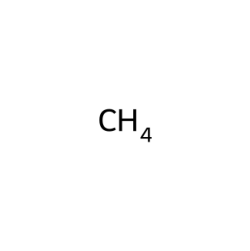

In [10]:
# methane
# Note how methane has a relatively high formation energy (compared to QM9)
# This correlates with lower thermodynamic stability and higher reactivity
# For example, methane readily burns in oxygen (CH₄ + 2O₂ → CO₂ + 2H₂O)
inspect_structure(0)

Atom │Number│    x     │    y     │    z     
─────┼──────┼──────────┼──────────┼──────────
  C  │  6   │    -0.034│     1.565│    -0.091
  C  │  6   │    -0.004│     0.042│    -0.037
  C  │  6   │    -1.372│    -0.568│     0.286
  C  │  6   │     0.729│    -0.677│    -1.196
  O  │  8   │     2.065│    -0.197│    -1.205
  C  │  6   │     1.750│    -1.289│    -0.309
  C  │  6   │     1.081│    -0.621│     0.888
  O  │  8   │     1.206│    -0.696│     2.073
  H  │  1   │     0.934│     1.962│    -0.403
  H  │  1   │    -0.799│     1.917│    -0.793
  H  │  1   │    -0.272│     1.973│     0.896
  H  │  1   │    -2.117│    -0.252│    -0.451
  H  │  1   │    -1.341│    -1.663│     0.290
  H  │  1   │    -1.707│    -0.240│     1.274
  H  │  1   │     0.321│    -1.078│    -2.117
  H  │  1   │     2.337│    -2.195│    -0.399


SMILE: CC1(C)C(=O)[C@@H]2O[C@@H]21


Formation Energy: -68.208
Formation Energy (normalized): 0.77356


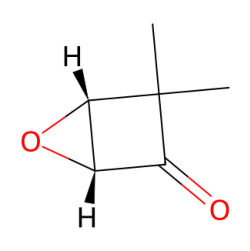

In [11]:
# random structure
inspect_structure(np.random.choice(range(len(smiles_data))))

## Task 1

## Task 1 - Building a model for geometric molecular representations

a. Converting Geometric representation of data (type_data and pos_data) into PyG-compatible Data objects

In [12]:
import torch
from torch_geometric.data import Dataset, Data
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from scipy.spatial import cKDTree 

class MoleculeGraphDataset(Dataset):
    def __init__(self, pos_data, type_data, fe_targets, idxes, radius=3.0):
        super().__init__()
        self.pos_data = pos_data
        self.type_data = type_data
        self.targets = fe_targets
        self.idxes = idxes
        self.radius = radius
        # self.encoder = OneHotEncoder(sparse=False)
        self.encoder = OneHotEncoder(sparse_output=False)
        self.encoder.fit(np.array([[1], [6], [7], [8], [9], [16]])) 

    def len(self):
        return len(self.idxes)

    def get(self, idx):
        real_idx = self.idxes[idx]
        pos = self.pos_data[real_idx]
        atom_types = self.type_data[real_idx].reshape(-1, 1)
        x = torch.tensor(self.encoder.transform(atom_types), dtype=torch.float) 
        pos = torch.tensor(pos, dtype=torch.float)

        tree = cKDTree(pos)
        # edge_index = torch.tensor(tree.query_pairs(r=self.radius), dtype=torch.long).T
        
        #fixing set to integer issue
        pairs = list(tree.query_pairs(r=self.radius))
        if len(pairs) > 0:
            edge_index = torch.tensor(pairs, dtype=torch.long).T
            edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)  # make bidirectional
        else:
            edge_index = torch.empty((2, 0), dtype=torch.long)

        # if edge_index.numel() > 0:
        #     edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)
        # else:
        #     edge_index = torch.empty((2, 0), dtype=torch.long)

        y = torch.tensor(self.targets[real_idx], dtype=torch.float).view(1)

        return Data(x=x, edge_index=edge_index, pos=pos, y=y)


C:\Users\anind\AppData\Roaming\Python\Python312\site-packages\torch_geometric\typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: Could not find module 'C:\Users\anind\AppData\Roaming\Python\Python312\site-packages\torch_scatter\_scatter_cuda.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
C:\Users\anind\AppData\Roaming\Python\Python312\site-packages\torch_geometric\typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: Could not find module 'C:\Users\anind\AppData\Roaming\Python\Python312\site-packages\torch_cluster\_grid_cuda.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
C:\Users\anind\AppData\Roaming\Python\Python312\site-packages\torch_geometric\typing.py:1

In [13]:
train_dataset = MoleculeGraphDataset(pos_data, type_data, fe, train_idxes)
test_dataset = MoleculeGraphDataset(pos_data, type_data, fe, test_idxes)

from torch_geometric.loader import DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)


Buildin GNN Model

In [14]:

from torch_geometric.nn import GCNConv, global_mean_pool

class GCNModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin1 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, 1)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = global_mean_pool(x, batch) 
        x = self.lin1(x)
        x = F.relu(x)
        x = self.lin2(x)
        return x.view(-1) 


Training the model

In [15]:
model = GCNModel(in_channels=6, hidden_channels=64) 

In [16]:
#optimizer and loss function
import torch
from torch_geometric.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()  #regression


In [17]:
#training and evaluating

def train():
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(out, batch.y.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_graphs
    return total_loss / len(train_loader.dataset)

# @torch.no_grad()
# def test(loader):
#     model.eval()
#     total_loss = 0
#     for batch in loader:
#         batch = batch.to(device)
#         out = model(batch.x, batch.edge_index, batch.batch)
#         loss = criterion(out, batch.y.view(-1))
#         total_loss += loss.item() * batch.num_graphs
#     return total_loss / len(loader.dataset)

@torch.no_grad()
def evaluate(loader):
    model.eval()
    total_loss = 0
    preds, targets = [], []
    for batch in loader:
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(out, batch.y.view(-1))
        total_loss += loss.item() * batch.num_graphs
        preds.extend(out.cpu().numpy())
        targets.extend(batch.y.view(-1).cpu().numpy())
    avg_loss = total_loss / len(loader.dataset)
    return avg_loss, preds, targets


In [ ]:
for epoch in range(1, 21):
    train_loss = train()
    test_loss, preds_x, targets_x = evaluate(test_loader)
    print(f"Epoch {epoch:02d}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

torch.save(model.state_dict(), 'gcn_model_weights.pt')
print("Model weights saved to gcn_model_weights.pt")

train_loss, train_preds, train_targets = evaluate(train_loader)
test_loss, test_preds, test_targets = evaluate(test_loader)

Epoch 01, Train Loss: 0.2304, Test Loss: 0.2112
Model weights saved to gcn_model_weights.pt


In [ ]:
#Unnormalizing
import numpy as np

train_preds = np.array(train_preds) * std + mu
train_targets = np.array(train_targets) * std + mu

test_preds = np.array(test_preds) * std + mu
test_targets = np.array(test_targets) * std + mu


In [ ]:
#Compute mse and mae
from sklearn.metrics import mean_absolute_error, mean_squared_error

train_mae = mean_absolute_error(train_targets, train_preds)
train_mse = mean_squared_error(train_targets, train_preds)

test_mae = mean_absolute_error(test_targets, test_preds)
test_mse = mean_squared_error(test_targets, test_preds)

print(f"GCN Model - Train MAE: {train_mae:.2f}, MSE: {train_mse:.2f}")
print(f"GCN Model - Test MAE: {test_mae:.2f}, MSE: {test_mse:.2f}")


GCN Model - Train MAE: 2.85, MSE: 22.42
GCN Model - Test MAE: 2.89, MSE: 22.46


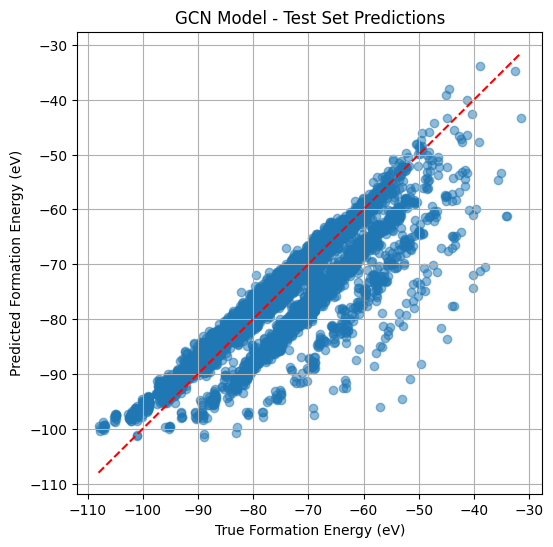

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(test_targets, test_preds, alpha=0.5)
plt.plot([min(test_targets), max(test_targets)],
         [min(test_targets), max(test_targets)], 'r--')
plt.xlabel("True Formation Energy (eV)")
plt.ylabel("Predicted Formation Energy (eV)")
plt.title("GCN Model - Test Set Predictions")
plt.grid(True)
plt.savefig("gcn_predictions_vs_true.png")
plt.show()


In [ ]:
# print(

SyntaxError: incomplete input (149104261.py, line 1)

## Task 1 - Building a model for SMILES molecular representations

a.

In [ ]:
from torch.nn.utils.rnn import pad_sequence
class SMILESTokenizer:
    def __init__(self, smiles_list):
        chars = set("".join(smiles_list))
        self.char2idx = {ch: i + 1 for i, ch in enumerate(sorted(chars))}
        self.char2idx["<PAD>"] = 0
        self.idx2char = {i: ch for ch, i in self.char2idx.items()}

    def encode(self, smile):
        return torch.tensor([self.char2idx[ch] for ch in smile], dtype=torch.long)

    def pad_batch(self, batch):
        return pad_sequence(batch, batch_first=True, padding_value=0)


In [ ]:
from torch.utils.data import Dataset

class SMILESDataset(Dataset):
    def __init__(self, smiles_list, fe_list, idx_list, tokenizer):
        self.smiles = [tokenizer.encode(smiles_list[i]) for i in idx_list]
        self.fe = torch.tensor([fe[i] for i in idx_list], dtype=torch.float)
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.fe)

    def __getitem__(self, idx):
        return self.smiles[idx], self.fe[idx]


In [ ]:
import torch.nn as nn

class SMILESModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=256):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.lin1 = nn.Linear(hidden_dim, hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.embedding(x)          # [B, L, D]
        _, h_n = self.gru(x)           # [1, B, H]
        h = h_n.squeeze(0)             # [B, H]
        h = torch.relu(self.lin1(h))
        return self.lin2(h).squeeze(1) # [B]


In [ ]:
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for smiles, targets in dataloader:
        smiles = tokenizer.pad_batch(smiles).to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        output = model(smiles)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * smiles.size(0)
    return total_loss / len(dataloader.dataset)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    preds, targets_all = [], []
    with torch.no_grad():
        for smiles, targets in dataloader:
            smiles = tokenizer.pad_batch(smiles).to(device)
            targets = targets.to(device)
            output = model(smiles)
            loss = criterion(output, targets)
            total_loss += loss.item() * smiles.size(0)
            preds.extend(output.cpu().numpy())
            targets_all.extend(targets.cpu().numpy())
    return total_loss / len(dataloader.dataset), preds, targets_all


In [ ]:
from torch.utils.data import DataLoader

# Tokenizer
tokenizer = SMILESTokenizer(smiles_data)

def collate_fn(batch):
    smiles_batch, target_batch = zip(*batch)
    smiles_batch = tokenizer.pad_batch(smiles_batch)
    target_batch = torch.stack(target_batch)
    return smiles_batch, target_batch

# Datasets
train_dataset = SMILESDataset(smiles_data, fe, train_idxes, tokenizer)
test_dataset = SMILESDataset(smiles_data, fe, test_idxes, tokenizer)

# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=64)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=64, collate_fn=collate_fn)


# Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SMILESModel(vocab_size=len(tokenizer.char2idx)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Training loop
for epoch in range(1, 21):
    train_loss = train(model, train_loader, optimizer, criterion, device)
    test_loss, _, _ = evaluate(model, test_loader, criterion, device)
    print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Test Loss = {test_loss:.4f}")

torch.save(model.state_dict(), "smiles_model_weights.pt")
print("Model weights saved to smiles_model_weights.pt")




Epoch 1: Train Loss = 0.1815, Test Loss = 0.0270
Epoch 2: Train Loss = 0.0122, Test Loss = 0.0055
Epoch 3: Train Loss = 0.0075, Test Loss = 0.0080
Epoch 4: Train Loss = 0.0078, Test Loss = 0.0059
Epoch 5: Train Loss = 0.0039, Test Loss = 0.0082


In [ ]:
#Run this only when you dont wanna train the model - this will load model weighys

# model = SMILESModel(vocab_size=len(tokenizer.char2idx)).to(device)
# model.load_state_dict(torch.load("smiles_model_weights.pt"))
# model.eval()

In [ ]:
train_loss, train_preds, train_targets = evaluate(train_loader, criterion, device)
test_loss, test_preds, test_targets = evaluate(test_loader, criterion, device)

In [ ]:
#unnormalize

train_preds = np.array(train_preds) * std + mu
train_targets = np.array(train_targets) * std + mu
test_preds = np.array(test_preds) * std + mu
test_targets = np.array(test_targets) * std + mu


In [ ]:
#compute mse and mae
from sklearn.metrics import mean_absolute_error, mean_squared_error

train_mae = mean_absolute_error(train_targets, train_preds)
train_mse = mean_squared_error(train_targets, train_preds)
test_mae = mean_absolute_error(test_targets, test_preds)
test_mse = mean_squared_error(test_targets, test_preds)

print(f"SMILES Model - Train MAE: {train_mae:.2f}, MSE: {train_mse:.2f}")
print(f"SMILES Model - Test MAE: {test_mae:.2f}, MSE: {test_mse:.2f}")


In [ ]:
#plot
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(test_targets, test_preds, alpha=0.5)
plt.plot([min(test_targets), max(test_targets)],
         [min(test_targets), max(test_targets)], 'r--')
plt.xlabel("True Formation Energy (eV)")
plt.ylabel("Predicted Formation Energy (eV)")
plt.title("SMILES Model – Test Set Predictions")
plt.grid(True)
plt.savefig("smiles_predictions_vs_true.png")
plt.show()


## Task 2

## Task 3

In [ ]:
def is_valid_smiles(smiles):
    if smiles is None:
        return False
    try:
        mol = Chem.MolFromSmiles(smiles)
        return mol is not None
    except:
        return False

def canonicalize(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return Chem.MolToSmiles(mol, canonical=True)
        return 'None'
    except:
        return 'None'

In [ ]:
canonicalize("COO"), canonicalize("O(C)O")

('COO', 'COO')

In [ ]:
is_valid_smiles("COO"), is_valid_smiles("O(C)O"), is_valid_smiles("C##")

(True, True, False)